In [1]:
from g2s.models.geometry_2_sphere import Mesh2Drag
from g2s.datasets.drag_dataset import DragDataset
from g2s.datasets.transforms.general import Compose
from g2s.datasets.transforms.radar import Log, Abs, Normalize, Center
from g2s.datasets.transforms.mesh import MeshNormalize

import numpy as np
import matplotlib.pyplot as plt
from torch_harmonics import plotting
from torch_geometric.loader import DataLoader
import xarray
import torch
from torch import nn
from pathlib import Path

from hydra_zen import load_from_yaml, instantiate, get_target
from mlflow import MlflowClient, set_tracking_uri

In [2]:
set_tracking_uri('geometry2sphere/datasets/out/mlflow')
runs = MlflowClient().search_runs(
    experiment_ids="429858339920414921",
)

In [ ]:
output_dir = runs[2].data.params['output_dir']
cfg = load_from_yaml(str(list(Path(output_dir).glob("**/config.yaml"))[0]))
o2s_5 = get_target(cfg.module)
o2s_5 = o2s_5.load_from_checkpoint(
    output_dir + '/model_epoch=3.ckpt',
    backbone=instantiate(cfg.module.backbone),
    criterion=instantiate(cfg.module.criterion),
    optim=instantiate(cfg.module.optim),
)

In [ ]:
output_dir = runs[0].data.params['output_dir']
cfg = load_from_yaml(str(list(Path(output_dir).glob("**/config.yaml"))[0]))
o2s_25 = get_target(cfg.module)
o2s_25 = o2s_25.load_from_checkpoint(
    output_dir + '/last.ckpt',
    backbone=instantiate(cfg.module.backbone),
    criterion=instantiate(cfg.module.criterion),
    optim=instantiate(cfg.module.optim),
)

In [5]:
output_dir = runs[0].data.params['output_dir']
cfg = load_from_yaml(str(list(Path(output_dir).glob("**/config.yaml"))[0]))
test_ds_fp = 'geometry2sphere/datasets/drag_sweep/'
ds = DragDataset(
    test_ds_fp,
    'train',
    seed=0,
    transform=instantiate(cfg.test_dataset.transform),
    shuffle_before_split=False,
    testing=True
)

In [6]:
dl = DataLoader(ds, batch_size=430, num_workers=0, shuffle=False)
itr = iter(dl)

In [7]:
mesh, flight_conds, coords, drag = next(itr)

In [20]:
with torch.no_grad():
    o2s_5_pred, _ = o2s_5((mesh.cuda(), flight_conds.cuda(), coords.cuda()))
    o2s_25_pred, w = o2s_25((mesh.cuda(), flight_conds.cuda(), coords.cuda()))

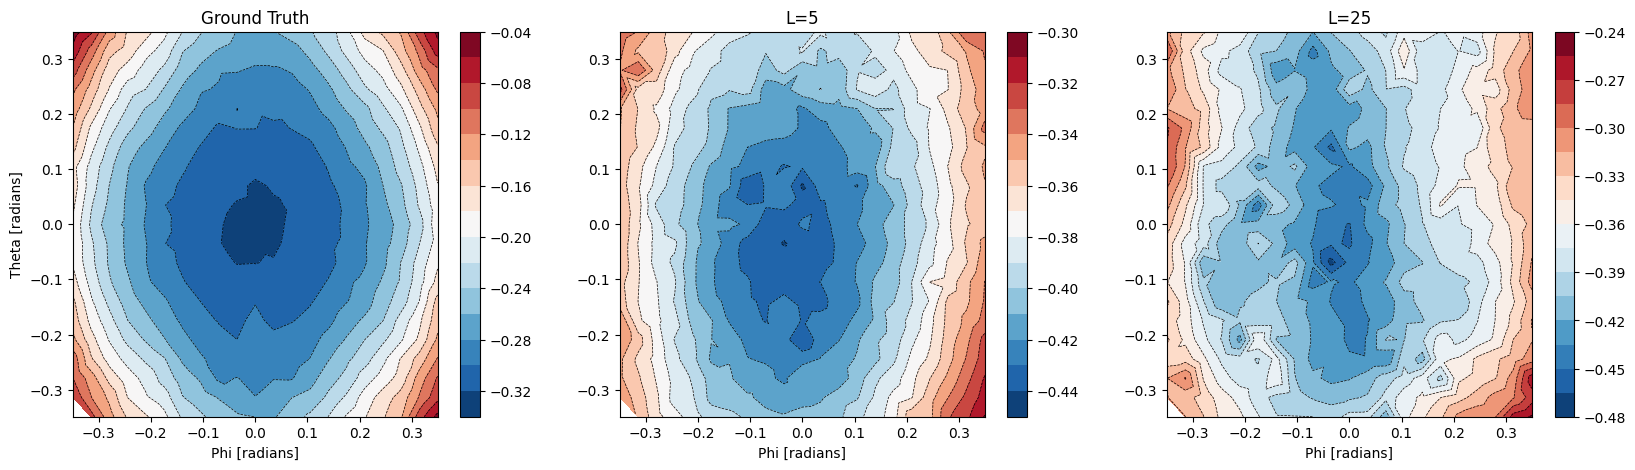

In [21]:
x = np.pi/ 2 - coords[:,0]
y = coords[:,1]
for i in range(coords[:,1].shape[0]):
    if y[i] > np.pi:
        y[i] -= 2* np.pi
        
z0 = drag.cpu().squeeze().numpy()
z1 = o2s_5_pred.cpu().squeeze().numpy()
z2 = o2s_25_pred.cpu().squeeze().numpy()

fig, ax, = plt.subplots(ncols=3, figsize=(20,5))
ax[0].tricontour(x, y, z0, levels=14, linewidths=0.5, colors='k')
cntr_gt = ax[0].tricontourf(x, y, z0, levels=14, cmap="RdBu_r")

ax[1].tricontour(x, y, z1, levels=14, linewidths=0.5, colors='k')
o2s_5_pred = ax[1].tricontourf(x, y, z1, levels=14, cmap="RdBu_r")

ax[2].tricontour(x, y, z2, levels=14, linewidths=0.5, colors='k')
o2s_25_pred = ax[2].tricontourf(x, y, z2, levels=14, cmap="RdBu_r")

fig.colorbar(cntr_gt, ax=ax[0])
ax[0].set_title(r'Ground Truth')
ax[0].set_xlabel(r'Phi [radians]')
ax[0].set_ylabel(r'Theta [radians]')

fig.colorbar(o2s_5_pred, ax=ax[1])
ax[1].set_title(r'L=5')
ax[1].set_xlabel(r'Phi [radians]')

fig.colorbar(o2s_25_pred, ax=ax[2])
ax[2].set_title(r'L=25')
ax[2].set_xlabel(r'Phi [radians]')

plt.savefig('drag_compare.png')